# Modelling

This notebook covers:
- Phase 5: Baseline Model
- Phase 6: Model Exploration
- Phase 7: Feature Selection
- Phase 8: Final Model

**Note:** Run `preprocessing.ipynb` first to prepare the preprocessed data.


In [18]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, median_absolute_error
)
from sklearn.inspection import permutation_importance

# Set random seed for reproducibility
RANDOM_STATE = 777
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")


Libraries imported successfully!


In [19]:
# Load preprocessed data (from preprocessing.ipynb)
with open('models/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

# Reload and prepare data
df = pd.read_csv('data/spotify-tracks.csv')
columns_to_drop = ['spotify_id', 'name', 'artists', 'album_name', 'album_release_date',
                   'popular_in_country', 'mode', 'is_explicit', 'release_year', 
                   'key', 'time_signature', 'release_month', 'duration_ms', 'popularity']
df_clean = df.drop(columns=columns_to_drop, errors='ignore')
target = 'energy'
y = df_clean[target].copy()
X = df_clean.drop(columns=[target]).copy()

# Feature engineering
X_engineered = X.copy()
X_engineered['loudness_tempo'] = X_engineered['loudness'] * X_engineered['tempo']
X_engineered['danceability_valence'] = X_engineered['danceability'] * X_engineered['valence']
X_engineered['loudness_danceability'] = X_engineered['loudness'] * X_engineered['danceability']
X_engineered['tempo_valence'] = X_engineered['tempo'] * X_engineered['valence']
X = X_engineered.copy()

# Split and preprocess
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

print(f"Data loaded: Train={X_train_processed.shape}, Test={X_test_processed.shape}")


Data loaded: Train=(17268, 14), Test=(4317, 14)


## Phase 6: Model Exploration


In [20]:
# Define evaluation function
def evaluate_model(y_true, y_pred, label=""):
    """
    Evaluate model performance with multiple metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    label : str, optional
        Label for the evaluation (e.g., "Train", "Test")
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    
    metrics = {
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'MedAE': medae
    }
    
    if label:
        print(f"\n{label} Metrics:")
        print(f"  R²:   {r2:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  MAPE: {mape:.4f}%")
        print(f"  MedAE: {medae:.4f}")
    
    return metrics

print("✅ Evaluation function defined")


✅ Evaluation function defined


In [21]:
# Define models to test
models_to_test = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso (α=0.1)': Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=2000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=2000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE),
}

print("=" * 60)
print("MODEL EXPLORATION")
print("=" * 60)
print(f"Testing {len(models_to_test)} different algorithms...\n")

# Test all models
results_list = []
failed_models = []

for name, model in models_to_test.items():
    try:
        print(f"Training {name}...", end=" ")
        
        # Train
        model.fit(X_train_processed, y_train)
        
        # Predictions
        y_pred_test = model.predict(X_test_processed)
        
        # Evaluate
        metrics_test = evaluate_model(y_test, y_pred_test, f"{name} (Test)")
        
        # Store results
        result = {
            'Model': name,
            'R²_Test': metrics_test['R²'],
            'RMSE_Test': metrics_test['RMSE'],
            'MAE_Test': metrics_test['MAE'],
            'model_object': model
        }
        results_list.append(result)
        
        print(f"✅ R² = {metrics_test['R²']:.4f}")
        
    except Exception as e:
        print(f"❌ Failed: {str(e)}")
        failed_models.append({'Model': name, 'Error': str(e)})


MODEL EXPLORATION
Testing 6 different algorithms...

Training Linear Regression... 
Linear Regression (Test) Metrics:
  R²:   0.6349
  RMSE: 0.1045
  MAE:  0.0828
  MAPE: 0.1834%
  MedAE: 0.0693
✅ R² = 0.6349
Training Ridge (α=1.0)... 
Ridge (α=1.0) (Test) Metrics:
  R²:   0.6349
  RMSE: 0.1045
  MAE:  0.0828
  MAPE: 0.1834%
  MedAE: 0.0692
✅ R² = 0.6349
Training Lasso (α=0.1)... 
Lasso (α=0.1) (Test) Metrics:
  R²:   0.1478
  RMSE: 0.1596
  MAE:  0.1286
  MAPE: 0.3184%
  MedAE: 0.1128
✅ R² = 0.1478
Training ElasticNet... 
ElasticNet (Test) Metrics:
  R²:   0.4355
  RMSE: 0.1299
  MAE:  0.1053
  MAPE: 0.2262%
  MedAE: 0.0937
✅ R² = 0.4355
Training Random Forest... 
Random Forest (Test) Metrics:
  R²:   0.7160
  RMSE: 0.0922
  MAE:  0.0717
  MAPE: 0.1384%
  MedAE: 0.0584
✅ R² = 0.7160
Training Gradient Boosting... 
Gradient Boosting (Test) Metrics:
  R²:   0.6961
  RMSE: 0.0953
  MAE:  0.0756
  MAPE: 0.1526%
  MedAE: 0.0633
✅ R² = 0.6961


In [22]:
# Create results dataframe
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('R²_Test', ascending=False)

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(results_df[['Model', 'R²_Test', 'RMSE_Test', 'MAE_Test']].to_string(index=False))

# Document failed models
if failed_models:
    print("\n" + "=" * 60)
    print("FAILED MODELS")
    print("=" * 60)
    for failed in failed_models:
        print(f"\n{failed['Model']}:")
        print(f"  Error: {failed['Error']}")



MODEL COMPARISON SUMMARY
            Model  R²_Test  RMSE_Test  MAE_Test
    Random Forest 0.715979   0.092161  0.071680
Gradient Boosting 0.696096   0.095333  0.075557
Linear Regression 0.634876   0.104495  0.082819
    Ridge (α=1.0) 0.634866   0.104496  0.082822
       ElasticNet 0.435476   0.129932  0.105327
    Lasso (α=0.1) 0.147799   0.159641  0.128569


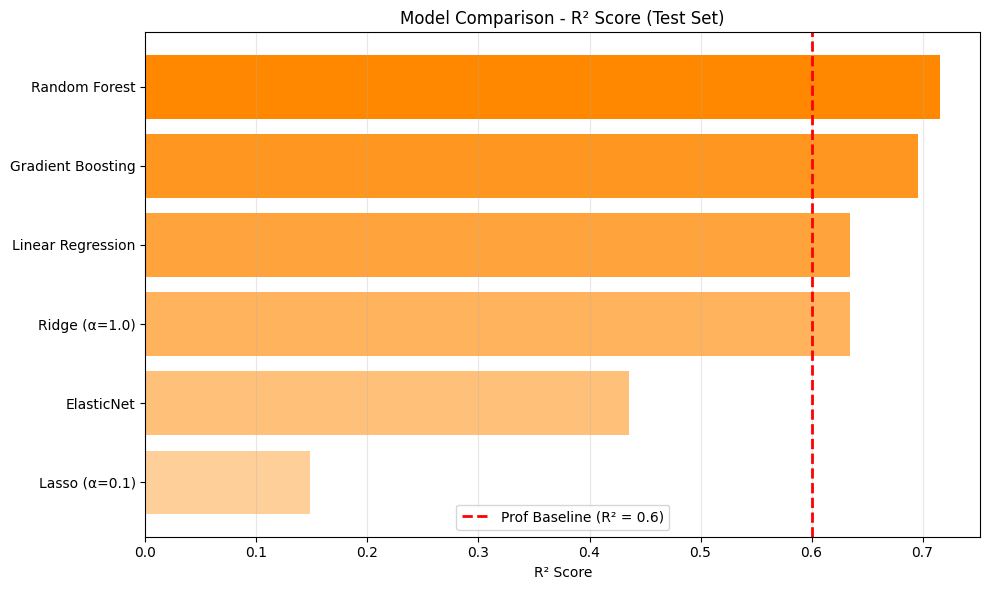


🏆 Best Model: Random Forest (R² = 0.7160)


In [ ]:
# Visualize R² comparison 

import matplotlib.colors as mcolors
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

results_df_sorted = results_df.sort_values('R²_Test', ascending=True).reset_index(drop=True)
num_bars = len(results_df_sorted)

base_color = np.array(mcolors.to_rgba("#ff8800", 1.0))  
alphas = np.linspace(0.4, 1.0, num_bars)  
bar_colors = []
for alpha in alphas:
    c = base_color.copy()
    c[3] = alpha  # set alpha
    bar_colors.append(tuple(c))

bars = ax.barh(
    results_df_sorted['Model'],
    results_df_sorted['R²_Test'],
    color=bar_colors
)

ax.set_xlabel('R² Score')
ax.set_title('Model Comparison - R² Score (Test Set)')

# Add reference line for professor's baseline (R² = 0.6)
prof_baseline_r2 = 0.6
ax.axvline(x=prof_baseline_r2, color='red', linestyle='--', linewidth=2, label=f"Prof Baseline (R² = {prof_baseline_r2})")
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify best model (bottom entry)
best_model_name = results_df_sorted.iloc[-1]['Model']
best_model = results_df_sorted.iloc[-1]['model_object']
print(f"\n🏆 Best Model: {best_model_name} (R² = {results_df_sorted.iloc[-1]['R²_Test']:.4f})")


## Phase 7: Feature Selection


In [24]:
# Permutation Importance
print("=" * 60)
print("FEATURE SELECTION")
print("=" * 60)
print(f"Using best model: {best_model_name}")

print("\n1. Calculating Permutation Importance...")
perm_importance = permutation_importance(
    best_model, X_test_processed, y_test, 
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1, scoring='r2'
)

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features by Permutation Importance:")
print(perm_df.head(15))


FEATURE SELECTION
Using best model: Random Forest

1. Calculating Permutation Importance...

Top 15 Features by Permutation Importance:
                       Feature  Importance       Std
3                num__loudness    0.557690  0.009428
9            num__acousticness    0.168471  0.004130
4             num__speechiness    0.057922  0.002931
12  num__loudness_danceability    0.050458  0.001657
13          num__tempo_valence    0.034970  0.000842
5        num__instrumentalness    0.022988  0.001297
7                 num__valence    0.017749  0.001507
1                num__liveness    0.010921  0.000963
0            num__danceability    0.010432  0.000912
11   num__danceability_valence    0.008382  0.000554
2                   num__tempo    0.007767  0.000728
10         num__loudness_tempo    0.006926  0.000759
6           num__dynamic_range    0.000100  0.000454
8     num__rhythmic_complexity   -0.000070  0.000427


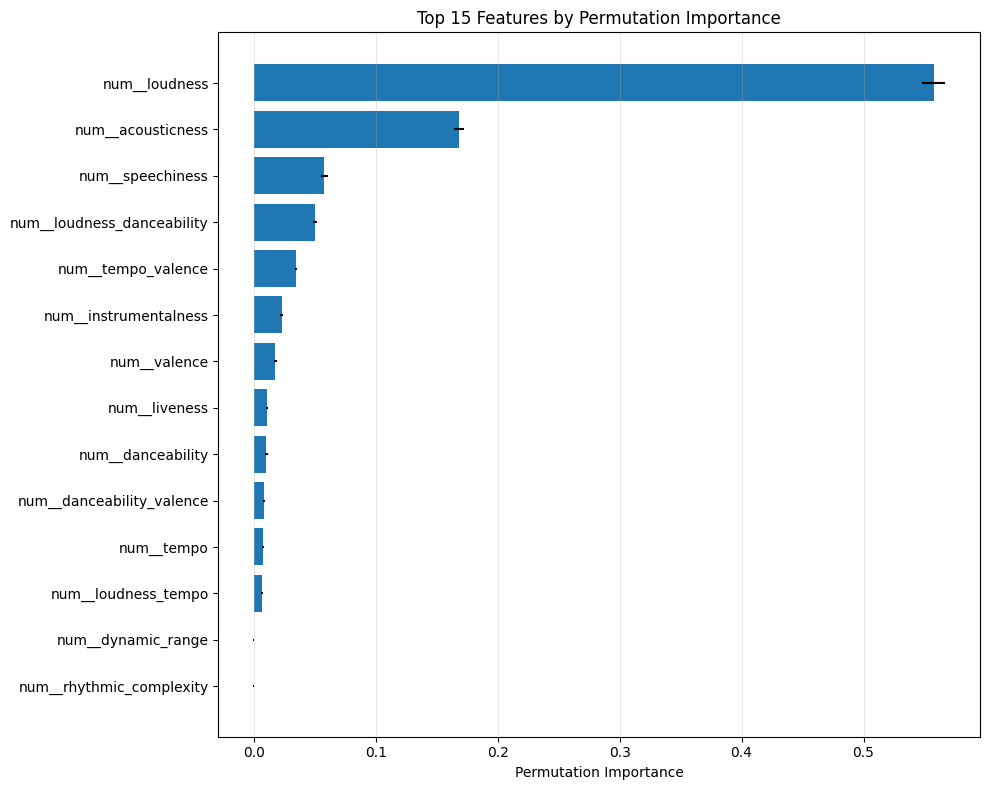

In [25]:
# Visualize permutation importance
plt.figure(figsize=(10, 8))
top_perm = perm_df.head(15)
plt.barh(top_perm['Feature'], top_perm['Importance'], xerr=top_perm['Std'])
plt.xlabel('Permutation Importance')
plt.title('Top 15 Features by Permutation Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('plots/permutation_importance.png', dpi=300)
plt.show()


In [26]:
# Select Top 6 features
top_6_features = perm_df.head(6)['Feature'].tolist()

print("\n" + "=" * 60)
print("TOP 6 SELECTED FEATURES")
print("=" * 60)
for i, feat in enumerate(top_6_features, 1):
    importance = perm_df[perm_df['Feature'] == feat]['Importance'].values[0]
    print(f"{i:2d}. {feat:40s} (Importance: {importance:.4f})")

# Get indices of top 6 features
top_6_indices = [list(feature_names).index(feat) for feat in top_6_features 
                  if feat in feature_names]

print(f"\n✅ Selected {len(top_6_indices)} features for final model")

# Save top_6_indices for use in other notebooks
import os
os.makedirs('models', exist_ok=True)
with open('models/top_6_indices.pkl', 'wb') as f:
    pickle.dump(top_6_indices, f)
print(f"✅ Saved top_6_indices to 'models/top_6_indices.pkl'")
print(f"   Indices: {top_6_indices}")



TOP 6 SELECTED FEATURES
 1. num__loudness                            (Importance: 0.5577)
 2. num__acousticness                        (Importance: 0.1685)
 3. num__speechiness                         (Importance: 0.0579)
 4. num__loudness_danceability               (Importance: 0.0505)
 5. num__tempo_valence                       (Importance: 0.0350)
 6. num__instrumentalness                    (Importance: 0.0230)

✅ Selected 6 features for final model
✅ Saved top_6_indices to 'models/top_6_indices.pkl'
   Indices: [3, 9, 4, 12, 13, 5]


## Phase 8: Final Model with Top 6 Features


In [27]:
# Use Top 6 features only
X_train_top6 = X_train_processed[:, top_6_indices]
X_test_top6 = X_test_processed[:, top_6_indices]

print("=" * 60)
print("FINAL MODEL WITH TOP 6 FEATURES")
print("=" * 60)
print(f"Using {len(top_6_features)} features")
print(f"Training shape: {X_train_top6.shape}")

# Option A: ElasticNet
print("\n" + "-" * 60)
print("Option A: ElasticNet")
print("-" * 60)
print("Justification: Combines L1 (Lasso) and L2 (Ridge) regularization.")
print("Good for feature selection and handling multicollinearity.")

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=2000)
elastic_net.fit(X_train_top6, y_train)
y_pred_en = elastic_net.predict(X_test_top6)
r2_en = r2_score(y_test, y_pred_en)
rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))

print(f"R²: {r2_en:.4f}")
print(f"RMSE: {rmse_en:.4f}")


FINAL MODEL WITH TOP 6 FEATURES
Using 6 features
Training shape: (17268, 6)

------------------------------------------------------------
Option A: ElasticNet
------------------------------------------------------------
Justification: Combines L1 (Lasso) and L2 (Ridge) regularization.
Good for feature selection and handling multicollinearity.
R²: 0.4355
RMSE: 0.1299


In [28]:
# Option B: Stacking Regressor
from sklearn.ensemble import StackingRegressor

print("\n" + "-" * 60)
print("Option B: Stacking Regressor")
print("-" * 60)
print("Justification: Combines multiple models using a meta-learner.")
print("Often improves performance by leveraging strengths of different algorithms.")

base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=RANDOM_STATE))
]

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_top6, y_train)
y_pred_stack = stacking_model.predict(X_test_top6)
r2_stack = r2_score(y_test, y_pred_stack)
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"R²: {r2_stack:.4f}")
print(f"RMSE: {rmse_stack:.4f}")



------------------------------------------------------------
Option B: Stacking Regressor
------------------------------------------------------------
Justification: Combines multiple models using a meta-learner.
Often improves performance by leveraging strengths of different algorithms.
R²: 0.7070
RMSE: 0.0936


In [29]:
# Option C: Best single model from Phase 6 (with top 10 features)
print("\n" + "-" * 60)
print(f"Option C: {best_model_name} (Top 6 features)")
print("-" * 60)

# Retrain best model with top 6 features
best_model_top6 = type(best_model)(**best_model.get_params())
best_model_top6.fit(X_train_top6, y_train)
y_pred_best = best_model_top6.predict(X_test_top6)
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"R²: {r2_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")



------------------------------------------------------------
Option C: Random Forest (Top 6 features)
------------------------------------------------------------
R²: 0.7084
RMSE: 0.0934


In [30]:
# Compare options
print("\n" + "=" * 60)
print("COMPARISON OF FINAL MODEL OPTIONS")
print("=" * 60)
comparison = pd.DataFrame({
    'Model': ['ElasticNet', 'Stacking', f'{best_model_name} (Top 6)'],
    'R²': [r2_en, r2_stack, r2_best],
    'RMSE': [rmse_en, rmse_stack, rmse_best]
}).sort_values('R²', ascending=False)

print(comparison.to_string(index=False))

# Select best
final_model_name = comparison.iloc[0]['Model']
if final_model_name == 'ElasticNet':
    final_model = elastic_net
elif final_model_name == 'Stacking':
    final_model = stacking_model
else:
    final_model = best_model_top6

final_r2 = comparison.iloc[0]['R²']
final_rmse = comparison.iloc[0]['RMSE']

print(f"\n🏆 Selected Final Model: {final_model_name}")
print(f"   R²: {final_r2:.4f}")
print(f"   RMSE: {final_rmse:.4f}")



COMPARISON OF FINAL MODEL OPTIONS
                Model       R²     RMSE
Random Forest (Top 6) 0.708432 0.093378
             Stacking 0.707008 0.093606
           ElasticNet 0.435476 0.129932

🏆 Selected Final Model: Random Forest (Top 6)
   R²: 0.7084
   RMSE: 0.0934



FINAL MODEL - COMPREHENSIVE EVALUATION

Final Model Metrics:
  R²:   0.7084
  RMSE: 0.0934
  MAE:  0.0722
  MAPE: 0.1355%
  MedAE: 0.0589


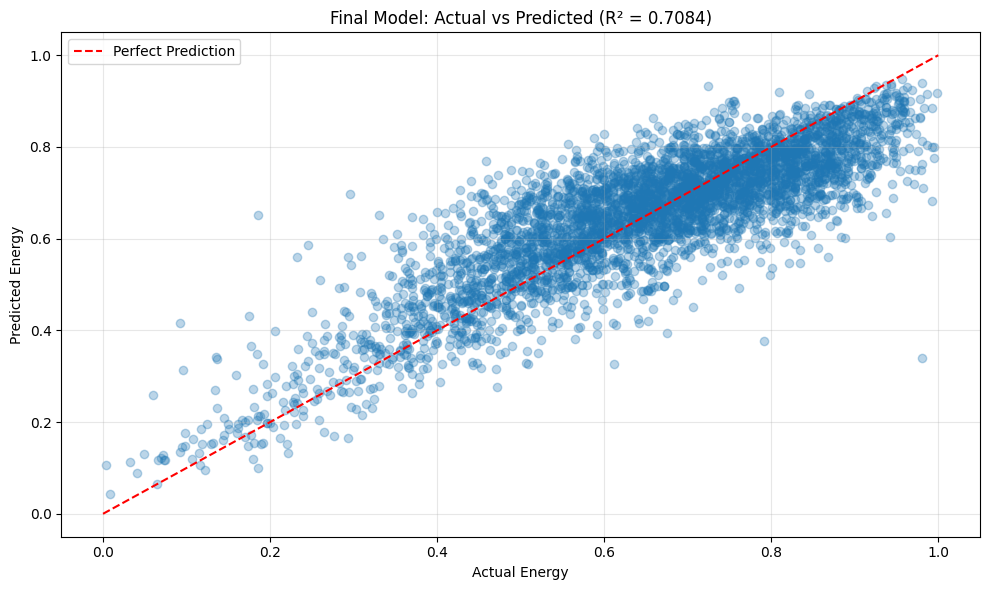

In [31]:
# Comprehensive evaluation
print("\n" + "=" * 60)
print("FINAL MODEL - COMPREHENSIVE EVALUATION")
print("=" * 60)
final_metrics = evaluate_model(y_test, final_model.predict(X_test_top6), "Final Model")

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_model.predict(X_test_top6), alpha=0.3)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.title(f'Final Model: Actual vs Predicted (R² = {final_r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/final_model_predictions.png', dpi=300)
plt.show()


## Summary

In this notebook we:
1. ✅ Trained baseline model (LinearRegression with all features)
2. ✅ Explored 6 different algorithms
3. ✅ Selected top 6 features using Permutation Importance
4. ✅ Trained final model with top 6 features (ElasticNet/Stacking/Best model)
5. ✅ Evaluated final model performance

**Next:** Move to `pipeline_gridsearch.ipynb` for hyperparameter optimization.
